In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import normaltest
from statannotations.Annotator import Annotator
import matplotlib.pyplot as plt
import scipy.stats as stats


sns.set(rc={'figure.figsize':(25,10)})

In [2]:
our_color_palette ={"WT": "#F2C14E", "KO": "#F15BB5", "OE": "#368F8B"}
genotype_dict = {"dicer_KO": "KO", "dicer_overexpressed": "OE", "wild_type": "WT", "dicer_ko": "KO", "dicer_over_expressing": "OE"}
passage_dict = {"passage_1": "P1", "passage_5": "P5", "passage_10": "P10"}
our_color_palette ={"WT": "#F2C14E", "KO": "#F15BB5", "OE": "#368F8B"}

genotype_order = ["WT", "KO", "OE"]
passage_order = ['P1','P5','P10']

### plot nucleotide diversity per protein

Values were computed with SNPGenie (https://github.com/chasewnelson/SNPGenie). 

In [3]:
df_WT= pd.read_csv('../../resources/run_workflow/results_cluster/wild_type/snpgenie_site_results.csv')
df_KO = pd.read_csv('../../resources/run_workflow/results_cluster/dicer_KO/snpgenie_site_results.csv')
df_OE = pd.read_csv('../../resources/run_workflow/results_cluster/dicer_overexpression/snpgenie_site_results.csv')

df_pi = pd.concat([df_WT, df_KO, df_OE])[['site', 'pi', 'genotype', 'replicate', 'passage']]

df_pi["genotype"] = df_pi["genotype"].apply(lambda x: genotype_dict[x])
df_pi["passage"] = df_pi["passage"].apply(lambda x: passage_dict[x])


In [4]:
proteins = {
    "1A": (799, 1089),
    "2A": (1092, 1161),
    "2B": (1164, 1587),
    "2C": (1590, 2901),
    "3A": (2904, 3501),
    "3C": (3504, 4422),
    "RdRp": (4425, 6072),
    "VP2": (6267, 7110),
    "VP4": (7113, 7281),
    "VP3": (7284, 8175),
    "VP1": (8175, 8970),
}

protein_order = list(proteins.keys())

In [5]:
df_pis_protein = pd.DataFrame() 

for genotype in genotype_order:
    for passage in passage_order:
        for replicate in ['replicate_d', 'replicate_b', 'replicate_a', 'replicate_e','replicate_c']:
            for protein in proteins.items():
                protein_id = protein[0]
                protein_start = protein[1][0]
                protein_end = protein[1][1]
                protein_length = protein_end - protein_start

                df_temp = df_pi[df_pi['genotype']== genotype]
                df_temp = df_temp[df_temp['passage']==passage]
                df_temp = df_temp[df_temp['replicate']==replicate]
                df_temp = df_temp[df_temp['site'].isin(list(range(protein_start,protein_end+1 )))]
                avg_pi = df_temp['pi'].sum()/protein_length

                mean_pis = {
                            'genotype': [genotype], 
                            'passage': passage, 
                            'replicate': replicate,
                            'protein': protein_id,
                            'avg_pi': avg_pi, 
                        }

                df_pis_protein = pd.concat([pd.DataFrame(mean_pis),df_pis_protein], ignore_index=True)


In [6]:
# test normalitiy for each group --> H0: samples comes from normal distribution

for protein in protein_order:
    avg_pi = df_pis_protein[(df_pis_protein['protein']==protein)].pivot_table(values ='avg_pi',
                                                                                           index=['genotype', 'passage'], 
                                                                                           aggfunc='mean').reset_index()['avg_pi']
    
 
    print(protein, ": p = ", normaltest(np.log10(avg_pi)).pvalue)

1A : p =  0.0742961733380507
2A : p =  0.06345354521359337
2B : p =  0.044843757819555456
2C : p =  0.5562845053818082
3A : p =  0.48200342315409395
3C : p =  0.6251844915555427
RdRp : p =  0.830185806382693
VP2 : p =  0.9677060887512499
VP4 : p =  0.24323373183863978
VP3 : p =  0.5799039043622394
VP1 : p =  0.43648289488253955


/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/scipy/stats/stats.p

In [7]:
# compare the baseline diveristy full genome (or coding) diversity to show that one protein is quite diverese

# import data

df_WT = pd.read_csv('../../resources/run_workflow/results_cluster/wild_type/snpgenie_population_summary.csv')
df_KO = pd.read_csv('../../resources/run_workflow/results_cluster/dicer_KO/snpgenie_population_summary.csv')
df_OE = pd.read_csv('../../resources/run_workflow/results_cluster/dicer_overexpression/snpgenie_population_summary.csv')


df_pop = pd.concat([df_WT, df_KO, df_OE])

df_pop["genotype"] = df_pop["genotype"].apply(lambda x: genotype_dict[x])
df_pop["passage"] = df_pop["passage"].apply(lambda x: passage_dict[x])
df_pop = df_pop[['pi','pi_coding', 'pi_noncoding', 'genotype', 'replicate', 'passage']]

df_pop_mean = df_pop.pivot_table(values ='pi_coding',
                                 index=['genotype', 'passage'], 
                                 aggfunc='mean')

df_pop_mean = df_pop_mean.reset_index()

/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:1781: UserWarning: You passed a edgecolor/edgecolors ((0.9490196078431372, 0.7568627450980392, 0.3058823529411765)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:1781: UserWarning: You passed a edgecolor/edgecolors ((0.9450980392156862, 0.3568627450980392, 0.7098039215686275)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:1781: UserWarning: You passed a edgecolor/edgecolors ((0.21176470588235294, 0.5607843137254902, 0.5450980392156862)) for an unfilled marker ('x').  Matplotlib is ignoring t

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

P10_WT vs. P10_OE: Custom statistical test, P_val:5.588e-02
P5_WT vs. P5_OE: Custom statistical test, P_val:2.430e-02
P1_WT vs. P1_OE: Custom statistical test, P_val:7.899e-01


/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:1781: UserWarning: You passed a edgecolor/edgecolors ((0.9490196078431372, 0.7568627450980392, 0.3058823529411765)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:1781: UserWarning: You passed a edgecolor/edgecolors ((0.9450980392156862, 0.3568627450980392, 0.7098039215686275)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:1781: UserWarning: You passed a edgecolor/edgecolors ((0.21176470588235294, 0.5607843137254902, 0.5450980392156862)) for an unfilled marker ('x').  Matplotlib is ignoring t

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

P10_WT vs. P10_OE: Custom statistical test, P_val:1.735e-02
P5_WT vs. P5_OE: Custom statistical test, P_val:9.328e-03
P1_WT vs. P1_OE: Custom statistical test, P_val:8.949e-01


/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:1781: UserWarning: You passed a edgecolor/edgecolors ((0.9490196078431372, 0.7568627450980392, 0.3058823529411765)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:1781: UserWarning: You passed a edgecolor/edgecolors ((0.9450980392156862, 0.3568627450980392, 0.7098039215686275)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:1781: UserWarning: You passed a edgecolor/edgecolors ((0.21176470588235294, 0.5607843137254902, 0.5450980392156862)) for an unfilled marker ('x').  Matplotlib is ignoring t

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

P10_WT vs. P10_OE: Custom statistical test, P_val:9.466e-02
P5_WT vs. P5_OE: Custom statistical test, P_val:1.669e-02
P1_WT vs. P1_OE: Custom statistical test, P_val:1.440e-01


/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:1781: UserWarning: You passed a edgecolor/edgecolors ((0.9490196078431372, 0.7568627450980392, 0.3058823529411765)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:1781: UserWarning: You passed a edgecolor/edgecolors ((0.9450980392156862, 0.3568627450980392, 0.7098039215686275)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:1781: UserWarning: You passed a edgecolor/edgecolors ((0.21176470588235294, 0.5607843137254902, 0.5450980392156862)) for an unfilled marker ('x').  Matplotlib is ignoring t

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

P10_WT vs. P10_OE: Custom statistical test, P_val:1.104e-01
P5_WT vs. P5_OE: Custom statistical test, P_val:4.473e-02
P1_WT vs. P1_OE: Custom statistical test, P_val:3.788e-02


/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:1781: UserWarning: You passed a edgecolor/edgecolors ((0.9490196078431372, 0.7568627450980392, 0.3058823529411765)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:1781: UserWarning: You passed a edgecolor/edgecolors ((0.9450980392156862, 0.3568627450980392, 0.7098039215686275)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:1781: UserWarning: You passed a edgecolor/edgecolors ((0.21176470588235294, 0.5607843137254902, 0.5450980392156862)) for an unfilled marker ('x').  Matplotlib is ignoring t

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

P10_WT vs. P10_OE: Custom statistical test, P_val:1.278e-02
P5_WT vs. P5_OE: Custom statistical test, P_val:2.902e-02
P1_WT vs. P1_OE: Custom statistical test, P_val:1.522e-02


/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:1781: UserWarning: You passed a edgecolor/edgecolors ((0.9490196078431372, 0.7568627450980392, 0.3058823529411765)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:1781: UserWarning: You passed a edgecolor/edgecolors ((0.9450980392156862, 0.3568627450980392, 0.7098039215686275)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:1781: UserWarning: You passed a edgecolor/edgecolors ((0.21176470588235294, 0.5607843137254902, 0.5450980392156862)) for an unfilled marker ('x').  Matplotlib is ignoring t

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

P10_WT vs. P10_OE: Custom statistical test, P_val:3.746e-02
P5_WT vs. P5_OE: Custom statistical test, P_val:1.180e-02
P1_WT vs. P1_OE: Custom statistical test, P_val:4.390e-02


/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:1781: UserWarning: You passed a edgecolor/edgecolors ((0.9490196078431372, 0.7568627450980392, 0.3058823529411765)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:1781: UserWarning: You passed a edgecolor/edgecolors ((0.9450980392156862, 0.3568627450980392, 0.7098039215686275)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:1781: UserWarning: You passed a edgecolor/edgecolors ((0.21176470588235294, 0.5607843137254902, 0.5450980392156862)) for an unfilled marker ('x').  Matplotlib is ignoring t

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

P10_WT vs. P10_OE: Custom statistical test, P_val:5.222e-03
P5_WT vs. P5_OE: Custom statistical test, P_val:1.965e-02
P1_WT vs. P1_OE: Custom statistical test, P_val:3.084e-02


/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:1781: UserWarning: You passed a edgecolor/edgecolors ((0.9490196078431372, 0.7568627450980392, 0.3058823529411765)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:1781: UserWarning: You passed a edgecolor/edgecolors ((0.9450980392156862, 0.3568627450980392, 0.7098039215686275)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:1781: UserWarning: You passed a edgecolor/edgecolors ((0.21176470588235294, 0.5607843137254902, 0.5450980392156862)) for an unfilled marker ('x').  Matplotlib is ignoring t

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

P10_WT vs. P10_OE: Custom statistical test, P_val:8.054e-01
P5_WT vs. P5_OE: Custom statistical test, P_val:5.235e-01
P1_WT vs. P1_OE: Custom statistical test, P_val:1.577e-01


/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:1781: UserWarning: You passed a edgecolor/edgecolors ((0.9490196078431372, 0.7568627450980392, 0.3058823529411765)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:1781: UserWarning: You passed a edgecolor/edgecolors ((0.9450980392156862, 0.3568627450980392, 0.7098039215686275)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:1781: UserWarning: You passed a edgecolor/edgecolors ((0.21176470588235294, 0.5607843137254902, 0.5450980392156862)) for an unfilled marker ('x').  Matplotlib is ignoring t

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

P10_WT vs. P10_OE: Custom statistical test, P_val:7.192e-01
P5_WT vs. P5_OE: Custom statistical test, P_val:7.761e-02
P1_WT vs. P1_OE: Custom statistical test, P_val:2.890e-01


/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:1781: UserWarning: You passed a edgecolor/edgecolors ((0.9490196078431372, 0.7568627450980392, 0.3058823529411765)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:1781: UserWarning: You passed a edgecolor/edgecolors ((0.9450980392156862, 0.3568627450980392, 0.7098039215686275)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:1781: UserWarning: You passed a edgecolor/edgecolors ((0.21176470588235294, 0.5607843137254902, 0.5450980392156862)) for an unfilled marker ('x').  Matplotlib is ignoring t

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

P10_WT vs. P10_OE: Custom statistical test, P_val:1.633e-02
P5_WT vs. P5_OE: Custom statistical test, P_val:4.184e-03
P1_WT vs. P1_OE: Custom statistical test, P_val:1.463e-02


/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:1781: UserWarning: You passed a edgecolor/edgecolors ((0.9490196078431372, 0.7568627450980392, 0.3058823529411765)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:1781: UserWarning: You passed a edgecolor/edgecolors ((0.9450980392156862, 0.3568627450980392, 0.7098039215686275)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:1781: UserWarning: You passed a edgecolor/edgecolors ((0.21176470588235294, 0.5607843137254902, 0.5450980392156862)) for an unfilled marker ('x').  Matplotlib is ignoring t

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

P10_WT vs. P10_OE: Custom statistical test, P_val:5.636e-01
P5_WT vs. P5_OE: Custom statistical test, P_val:7.779e-01
P1_WT vs. P1_OE: Custom statistical test, P_val:2.388e-02


Text(107.6231859375, 0.5, 'nucleotide diversity')

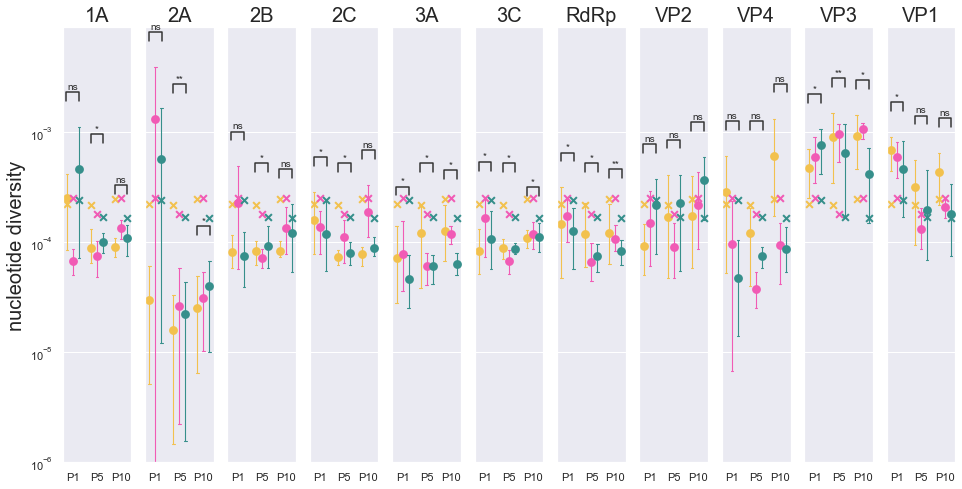

In [8]:
# 1. Take average over the replicates per passage per genotype 
# 2. Compare protein diversity to baseline diveristy 

fig, ax = plt.subplots(1,len(protein_order),  sharey=True, figsize=(16,8))

annotation_pairs = [(("P1", "WT"), ("P1", "OE")),
                    (("P5", "WT"), ("P5", "OE")), 
                    (("P10", "WT"), ("P10", "OE"))]

for idx, protein in enumerate(protein_order):

    sns.pointplot(
            ax= ax[idx], 
            data=df_pis_protein[df_pis_protein['protein']==protein], 
            markers='o', 
            linestyles='',
            x="passage", 
            y='avg_pi', 
            hue ='genotype', 
            errorbar="se",
            hue_order=genotype_order, 
            palette=our_color_palette,
            order =passage_order,
            errwidth=1.1, 
            capsize=0.1,
            dodge=0.5,
            legend=False
        )
    
    sns.pointplot(
            ax= ax[idx], 
            data=df_pop_mean, 
            markers='x', 
            linestyles='',
            x="passage", 
            y='pi_coding', 
            hue ='genotype', 
            errorbar='se',
            hue_order=genotype_order, 
            order =passage_order,
            palette=our_color_palette,
            errwidth=1.1, 
            capsize=0.1,
            dodge=0.5,
            legend=False
        )
    ax[idx].set_yscale('log')
    ax[idx].set_ylim((10e-07, 0.009))
    
    
    df_pis_protein_mean = df_pis_protein[(df_pis_protein['protein']==protein)].pivot_table(values ='avg_pi',
                                                                                           index=['genotype', 'passage'], 
                                                                                           aggfunc='mean').reset_index()
    
    
    p_values =[stats.ttest_rel(np.log10(df_pis_protein_mean[df_pis_protein_mean['passage']=='P1']['avg_pi']), 
                           np.log10(df_pop_mean[df_pop_mean['passage']=='P1']['pi_coding']), 
                           alternative="two-sided").pvalue,
              stats.ttest_rel(np.log10(df_pis_protein_mean[df_pis_protein_mean['passage']=='P5']['avg_pi']), 
                           np.log10(df_pop_mean[df_pop_mean['passage']=='P5']['pi_coding']), 
                           alternative="two-sided").pvalue,
              stats.ttest_rel(np.log10(df_pis_protein_mean[df_pis_protein_mean['passage']=='P10']['avg_pi']), 
                           np.log10(df_pop_mean[df_pop_mean['passage']=='P10']['pi_coding']), 
                           alternative="two-sided").pvalue]

    
    # subset the table otherwise the stats were calculated on the whole dataset
    annot = Annotator(ax[idx],
                      annotation_pairs, 
                      data=df_pis_protein[df_pis_protein['protein']==protein], 
                      x="passage", 
                      y='avg_pi', 
                      hue ='genotype',  
                      order=passage_order,
                      hue_order=genotype_order) 
    
    annot.configure(test=None,loc='inside', verbose=2).set_pvalues(p_values).annotate()
    
    ax[idx].set_title(protein, fontsize=20)
    ax[idx].set_ylabel("")
    ax[idx].set_xlabel("")
    ax[idx].get_legend().remove()
    

ax[0].set_ylabel("nucleotide diversity", fontsize=20)


In [9]:
fig.savefig("./000__Manuscript_figures/Supplement_Figure_3B__nucleotide_diversity_protein.pdf")
fig.savefig("./000__Manuscript_figures/Supplement_Figure_3B__nucleotide_diversity_protein.svg")